In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import datetime
import seaborn as sns

In [2]:
%matplotlib inline

# Dataset 1

In [3]:
df = pd.read_csv('googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
df_len = len(df)
print('Number of rows:', df_len)

Number of rows: 10841


## Cleaning Data

Many columns have **no** missing values  
Rows have no more than two missing values  
Column "Reviews" has significant amounts of missing values  

In [5]:
print(df.isna().sum(axis=1).value_counts())
df.isna().sum()

0    9360
1    1475
2       6
dtype: int64


App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

### Shifted Row

![title](incorrect_row.png)

In [6]:
df.loc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [7]:
df.loc[10472, df.columns != 'App'] = df.loc[10472, df.columns != 'App'].shift(1, fill_value="None")
df.loc[10472, 'Rating'] = float(df.loc[10472, 'Rating'])

In [8]:
df.loc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                             None
Rating                                                1.9
Reviews                                              19.0
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                                NaN
Last Updated                            February 11, 2018
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

### Columns

In [9]:
df.dtypes

App               object
Category          object
Rating            object
Reviews           object
Size              object
Installs          object
Type              object
Price             object
Content Rating    object
Genres            object
Last Updated      object
Current Ver       object
Android Ver       object
dtype: object

**Changes**:  

Columns that should be integers but are string:

    - Reviews
    - Size (Bytes)
    - Installs
Columns that should be floats but are strings:

    - Price
    - Rating
    
Columns that should be datetime objects but are strings:

    - Last Updated
    
Redundant columns:

    - Type

#### Rating

In [10]:
df['Rating'] = df['Rating'].map(lambda x: float(x))

In [11]:
df['Rating'].isna().sum()

1474

**Problem:** 13-14% of data is NaN  
**Chosen solution:** keep data as NaN, it should be easy to treat the values as removed using *skipna=True*

> Advantages:  
> - It is immediately clear that the data is missing  
> - It still allows easy computations such as mean() using *skipna=True*
> - No loss of other data that would occur if the rows were removed

#### Reviews

In [12]:
print(df['Reviews'].unique())

['159' '967' '87510' ... '603' '1195' '398307']


There is **one** non-str entry, in the shifted row

In [13]:
for i, row in df.iterrows():
    if type(row['Reviews']) == str and not row['Reviews'].isnumeric():
        print(row['Reviews'])
    elif type(row['Reviews']) != str:
        print(row['Reviews'])

19.0


In [14]:
df['Reviews'] = df['Reviews'].map(lambda val: int(val))
df['Reviews']

0           159
1           967
2         87510
3        215644
4           967
          ...  
10836        38
10837         4
10838         3
10839       114
10840    398307
Name: Reviews, Length: 10841, dtype: int64

#### Size

In [15]:
print(df['Size'].unique()[190:210])

['92M' '83M' '88M' '704k' '862k' '899k' '378k' '266k' '375k' '1.3M' '975k'
 '980k' '4.1M' '89M' '696k' '544k' '525k' '920k' '779k' '853k']


In [16]:
other_values = defaultdict(lambda:0)
for i, row in df.iterrows():
    if row['Size'][-1] not in 'Mk':
        other_values[row['Size']] += 1
for k, v in other_values.items():
    print(k, v)

Varies with device 1695


**Problem:** Varies with device provides no information.  
**Chosen Solution:** Replace with NaN.  
> Advantages:  
> - It is immediately clear that the data is missing  
> - It still allows easy computations such as mean() using *skipna=True*
> - No loss of other data that would occur if the rows were removed

> Disadvantages:  
> - It forces the column data type to be float, while int is a better representation

In [17]:
def clean_size(val):
    if type(val) == int or type(val) == float:
        return val
    elif val == 'Varies with device':
        return np.nan
    elif val.endswith('k'):
        return int(float(val[:-1]) * 1000)
    elif val.endswith('M'):
        return int(float(val[:-1]) * 1000000)
    return int(val)

df['Size'] = df['Size'].map(clean_size)

In [18]:
df['Size'].mean(skipna = True)

21514504.9661054

#### Installs

In [19]:
df['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', '0'], dtype=object)

In [20]:
# df['Installs'].map(lambda i: int(i.strip('+').replace(',', '') if i != 'Free' else 0))
def clean_install(val):
    if type(val) == int:
        return val
    val = val.strip('+')
    val = val.replace(',', '')
    return int(val)

df['Installs'] = df['Installs'].map(clean_install)
df['Installs']

0           10000
1          500000
2         5000000
3        50000000
4          100000
           ...   
10836        5000
10837         100
10838        1000
10839        1000
10840    10000000
Name: Installs, Length: 10841, dtype: int64

#### Price

In [21]:
df['Price'].unique()[:12]

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49'], dtype=object)

In [22]:
def clean_price(val):
    if type(val) == float:
        return val
    val = val.strip('$')
    return float(val)
df['Price'] = df['Price'].map(clean_price)
df['Price']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
10836    0.0
10837    0.0
10838    0.0
10839    0.0
10840    0.0
Name: Price, Length: 10841, dtype: float64

#### Last Updated

In [23]:
df['Last Updated'].unique()

array(['January 7, 2018', 'January 15, 2018', 'August 1, 2018', ...,
       'January 20, 2014', 'February 16, 2014', 'March 23, 2014'],
      dtype=object)

In [24]:
def clean_last_updated(val):
    if type(val) == datetime.date:
        return val
    return datetime.datetime.strptime(val, '%B %d, %Y')
    
df['Last Updated'] = df['Last Updated'].map(clean_last_updated)
df['Last Updated']

0       2018-01-07
1       2018-01-15
2       2018-08-01
3       2018-06-08
4       2018-06-20
           ...    
10836   2017-07-25
10837   2018-07-06
10838   2017-01-20
10839   2015-01-19
10840   2018-07-25
Name: Last Updated, Length: 10841, dtype: datetime64[ns]

#### Type

One NaN value, where price == 0. Should be 'Free'.

In [25]:
df['Type'].value_counts(dropna=False)

Free    10040
Paid      800
NaN         1
Name: Type, dtype: int64

Check whether Type column does indeed match Price column:

In [26]:
print(((df['Type'].fillna('Free') == 'Free') == (df['Price'] == 0)).mean())

1.0


Remove Type column:

In [27]:
df.drop(columns=['Type'], inplace=True)

#### Other

In [28]:
df[["Genres", "Current Ver", "Android Ver"]] = df[["Genres", "Current Ver", "Android Ver"]].fillna("")

Over 50% of the "Genres" column is a duplicate of the 'Category' Column:

In [29]:
(df['Category'].map(lambda x: x.lower()) == df['Genres'].map(lambda x: x.lower())).mean()

0.5342680564523568

Some categories have genres, some do not. For example, **all** games have their own genres:

In [30]:
def cat_genre_percent(cat):
    return (df[df['Category']==cat]['Category'].map(lambda x: x.lower()) == df[df['Category']==cat]['Genres'].map(lambda x: x.lower())).mean()

print("{:20s}  {}".format("- CATEGORY - ", "- Percent Duplicate -"))
for cat in df['Category'].unique():
    print("{:20s}  {}".format(cat, cat_genre_percent(cat)))

- CATEGORY -          - Percent Duplicate -
ART_AND_DESIGN        0.0
AUTO_AND_VEHICLES     0.0
BEAUTY                1.0
BOOKS_AND_REFERENCE   0.0
BUSINESS              1.0
COMICS                0.9833333333333333
COMMUNICATION         1.0
DATING                1.0
EDUCATION             0.8269230769230769
ENTERTAINMENT         0.912751677852349
EVENTS                1.0
FINANCE               1.0
FOOD_AND_DRINK        0.0
HEALTH_AND_FITNESS    0.0
HOUSE_AND_HOME        0.0
LIBRARIES_AND_DEMO    0.0
LIFESTYLE             0.9973821989528796
GAME                  0.0
FAMILY                0.0
MEDICAL               1.0
SOCIAL                1.0
SHOPPING              1.0
PHOTOGRAPHY           1.0
SPORTS                1.0
TRAVEL_AND_LOCAL      0.0
TOOLS                 0.9988137603795967
PERSONALIZATION       1.0
PRODUCTIVITY          1.0
PARENTING             0.7666666666666667
WEATHER               1.0
VIDEO_PLAYERS         0.0
NEWS_AND_MAGAZINES    0.0
MAPS_AND_NAVIGATION   0.0
None     

### Duplicate rows

There are 483 **duplicate** rows:

In [31]:
df.duplicated().sum()

483

Duplicates of existing rows are **dropped**:

In [32]:
df.drop_duplicates(inplace=True)

Still, many apps have multiple entries in the database:

In [33]:
df['App'].value_counts()

ROBLOX                                           9
8 Ball Pool                                      7
Bubble Shooter                                   6
Helix Jump                                       6
Zombie Catchers                                  6
                                                ..
Theme Android P Black design for LG V30          1
Popsicle Launcher for Android P 9.0 launcher     1
PixelLab - Text on pictures                      1
P Launcher for Android™ 9.0                      1
iHoroscope - 2018 Daily Horoscope & Astrology    1
Name: App, Length: 9660, dtype: int64

These entries are **near duplicates**, only differing slightly in the number of reviews:

In [34]:
df[df['App'] == 'ROBLOX']

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1653,ROBLOX,GAME,4.5,4447388,67000000.0,100000000,0.0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
1701,ROBLOX,GAME,4.5,4447346,67000000.0,100000000,0.0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
1748,ROBLOX,GAME,4.5,4448791,67000000.0,100000000,0.0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
1841,ROBLOX,GAME,4.5,4449882,67000000.0,100000000,0.0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
1870,ROBLOX,GAME,4.5,4449910,67000000.0,100000000,0.0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
2016,ROBLOX,FAMILY,4.5,4449910,67000000.0,100000000,0.0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
2088,ROBLOX,FAMILY,4.5,4450855,67000000.0,100000000,0.0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
2206,ROBLOX,FAMILY,4.5,4450890,67000000.0,100000000,0.0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
4527,ROBLOX,FAMILY,4.5,4443407,67000000.0,100000000,0.0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up


Some different apps have the same name:

In [35]:
df[df['App'] == 'Calculator']

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
477,Calculator,DATING,2.6,57,6200000.0,1000,6.99,Everyone,Dating,2017-10-25,1.1.6,4.0 and up
3242,Calculator,TOOLS,4.3,40770,NaN,100000000,0.00,Everyone,Tools,2017-11-21,Varies with device,Varies with device


However, **most** same-named apps with many different columns **seem** to actually be the same app. (checked manually)

In [36]:
counts = df['App'].value_counts()
keep_names = []
for app in df['App'].unique():
    if counts[app] > 1:
        # Count number of columns (out of 13) that have 0 or 1 unique values:
        unique_counts = df[df['App'] == app].nunique().value_counts()
        n = (unique_counts[0] if 0 in unique_counts else 0) + (unique_counts[1] if 1 in unique_counts else 0)
        
        if n <= 9:
            keep_names.append(app)
keep_names

['Call Blocker',
 'Calculator',
 'Duolingo: Learn Languages Free',
 'English Grammar Test',
 'Edmodo',
 'Panera Bread',
 'Period Tracker',
 'Ruler',
 'Solitaire',
 'Bubble Shooter',
 'Word Search',
 'Farm Heroes Saga',
 'Chess Free',
 'Fun Kid Racing - Motocross',
 'Video Editor',
 'Cardiac diagnosis (heart rate, arrhythmia)',
 'Blood Pressure',
 'mySugr: the blood sugar tracker made just for you',
 'High Blood Pressure Symptoms',
 'letgo: Buy & Sell Used Stuff, Cars & Real Estate',
 'My Photo Keyboard',
 'Photo Editor',
 'Flashlight',
 'Chrome Beta']

Therefore, it was decided to **remove** all rows with duplicate app names.

In [37]:
df = df.sort_values('Last Updated', ascending=False).drop_duplicates('App').sort_index()

*In Memoriam*:  

    * Calculator  
    * Call Blocker  
    * English Grammar Test

# Dataset 2

In [38]:
df2 = pd.read_csv('googleplaystore_user_reviews.csv')
df2_len = len(df2)
print('Number of rows:', df2_len)
df2.head()

Number of rows: 64295


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


## Cleaning Data:

### Drop Rows

Column "App" is **always** present.  
**Almost all** rows that have NaN values have no information except the app title.  
**5** rows are missing "Translated_Review" but are otherwise complete.

In [39]:
print(df2.isna().sum(axis=1).value_counts())
df2.isna().sum()

0    37427
4    26863
1        5
dtype: int64


App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

These rows with 4 NaN values are dropped:

In [40]:
total = len(df2)
df2 = df2.dropna(thresh=2)
after = len(df2)
print("{}/{} rows dropped ({:.2f})".format(total-after, total, 1-after/total))

26863/64295 rows dropped (0.42)


This dataset does **not** contain duplicate rows. 

In [41]:
df.duplicated().sum()

0

### Columns

#### Translated Review

Fill NaNs with empty string, this column will likely not be used anyways

In [42]:
df2['Translated_Review'] = df2['Translated_Review'].fillna("")
df2['Translated_Review'].isna().sum()

0

#### Sentiment

In [43]:
df2['Sentiment'].value_counts()

Positive    23998
Negative     8271
Neutral      5163
Name: Sentiment, dtype: int64

In [44]:
d = {'Positive':1, 'Neutral':0, 'Negative':-1}
df2['Sentiment'] = df2['Sentiment'].map(d)

In [45]:
df2.groupby('App').mean(numeric_only=True)#.sort_values(by="Sentiment", ascending=False)

,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
App,,,
10 Best Foods for You,0.783505,0.470733,0.495455
104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,0.750000,0.392405,0.545516
11st,0.400000,0.181294,0.443957
1800 Contacts - Lens Store,0.725000,0.318145,0.591098
1LINE – One Line with One Touch,0.500000,0.196290,0.557315
...,...,...,...
Hotels.com: Book Hotel Rooms & Find Vacation Deals,0.264706,0.101622,0.545444
Hotspot Shield Free VPN Proxy & Wi-Fi Security,0.411765,0.251765,0.393284
Hotstar,0.000000,0.038178,0.493964


In [46]:
df2['Sentiment_Polarity'].min(), df2['Sentiment_Polarity'].max()

(-1.0, 1.0)

In [47]:
df2['Sentiment_Subjectivity'].min(), df2['Sentiment_Subjectivity'].max()

(0.0, 1.0)

# Joining Some Tables

In [48]:
df_comb = pd.merge(df, df2, how='inner', on='App')
df_comb.head()

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,A kid's excessive ads. The types ads allowed a...,-1,-0.250,1.000000
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,It bad >:(,-1,-0.725,0.833333
2,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,like,0,0.000,0.000000
3,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,I love colors inspyering,1,0.500,0.600000
4,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,I hate,-1,-0.800,0.900000


In [49]:
print(len(df2))
print(len(df_comb))

37432
35934


# Analysis

## High-Level Statistics

In [50]:
print("Number of rows in app database:      {}/{} ({:.2f})".format( len(df), df_len, len(df)/df_len ))
print("Number of rows in review database:   {}/{} ({:.2f})".format( len(df2), df2_len, len(df2)/df2_len))
print("Number of apps in review database:   {}".format(df2['App'].nunique()))
print("Number of apps in combined database: {}".format(df_comb['App'].nunique()))
print("Number of categories in database:    {}".format(df['Category'].nunique()))
print("Number of paid apps in database:     {}/{} ({:.2f})".format((df['Price'] > 0).sum(), len(df), (df['Price'] > 0).sum() / len(df)))


Number of rows in app database:      9660/10841 (0.89)
Number of rows in review database:   37432/64295 (0.58)
Number of apps in review database:   865
Number of apps in combined database: 816
Number of categories in database:    34
Number of paid apps in database:     754/9660 (0.08)


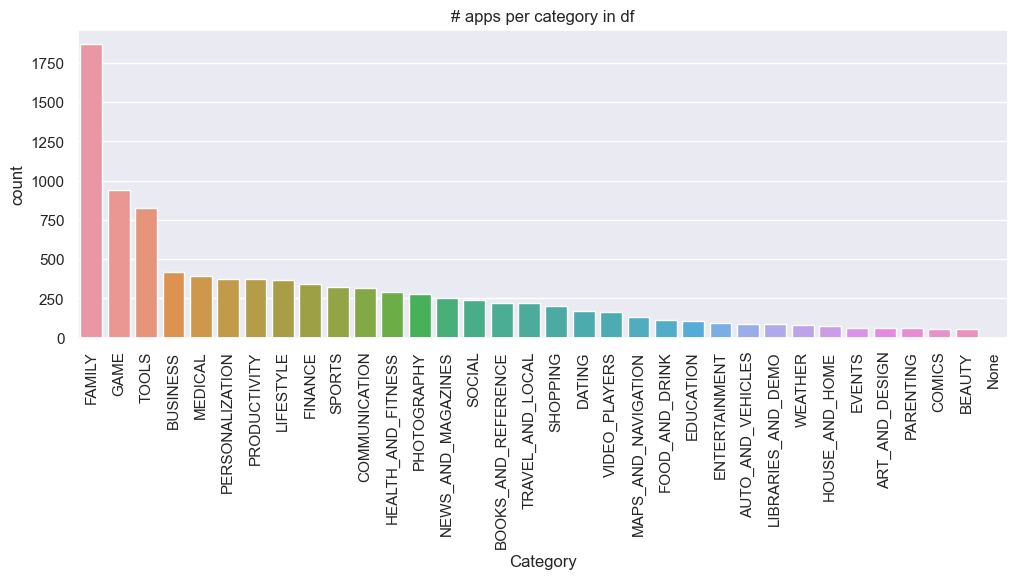

In [51]:
sns.set(rc={"figure.figsize":(12, 4)})
plt.xticks(rotation=90)
sns.countplot(x='Category', data=df, order=df['Category'].value_counts().index)
plt.title('# apps per category in df')
plt.show()

**Takeaways:** 

- ~90% of the data in the app database was kept  
- ~60% of the data in the review database was kept
- Almost all data in the database concerns free apps.
- *Family* is the most common app category by far. *Game* and *Tools* also have a significant presence.


## Correlation

<AxesSubplot:>

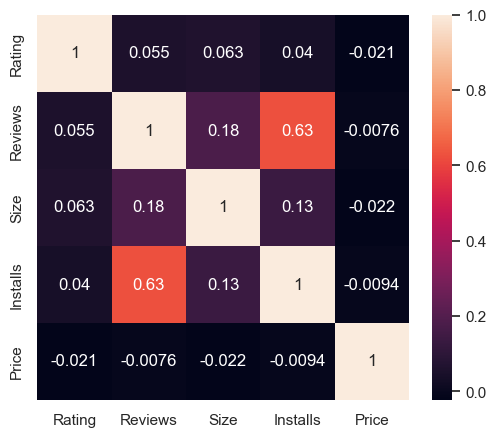

In [52]:
sns.set(rc={"figure.figsize":(6, 5)})
sns.heatmap(df.corr(numeric_only = True, method="pearson"), annot=True)

<AxesSubplot:>

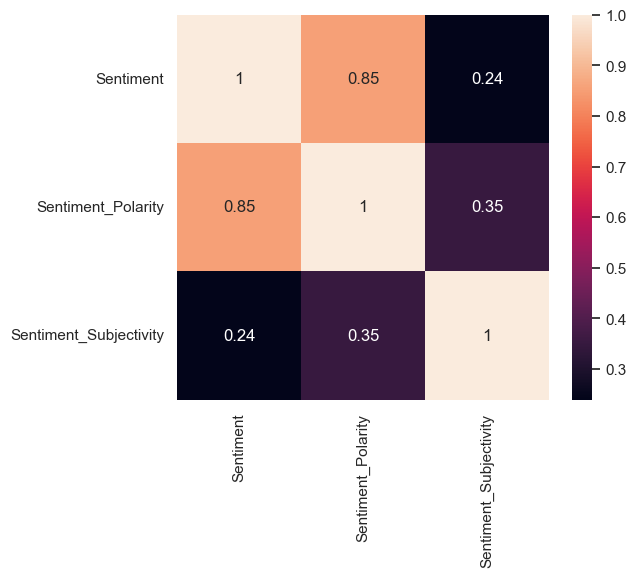

In [53]:
sns.heatmap(df2.corr(numeric_only = True, method="spearman"), annot=True)

<AxesSubplot:>

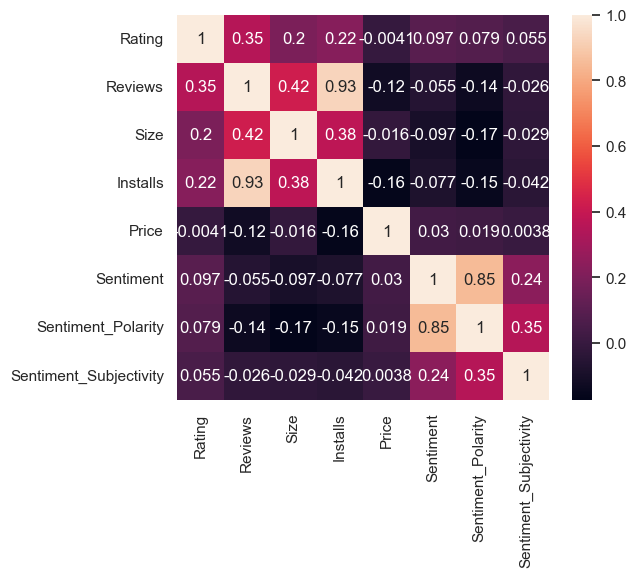

In [54]:
sns.heatmap(df_comb.corr(numeric_only = True, method="spearman"), annot=True)

## Plots

In [55]:
sns.set(rc={"figure.figsize":(12, 4)})

In [56]:
def barplot(df, gby, col, ordby = None, color='blue', title=''):
    if ordby is None:
        order = df.groupby(gby)[[gby,col]].mean(col).sort_values(col, ascending=False).dropna().reset_index()
    else:
        order = df.groupby(gby)[[gby,col,ordby]].mean(ordby).sort_values(ordby, ascending=False).dropna().reset_index()  
        
    bp = sns.barplot(x=df[gby], y=df[col], color=color, saturation=0.5, order=order[gby])
    plt.xticks(rotation=90)
    bp.set_xticklabels(order[gby], size = 12)
    bp.set(title=title)
    return bp

### All apps:

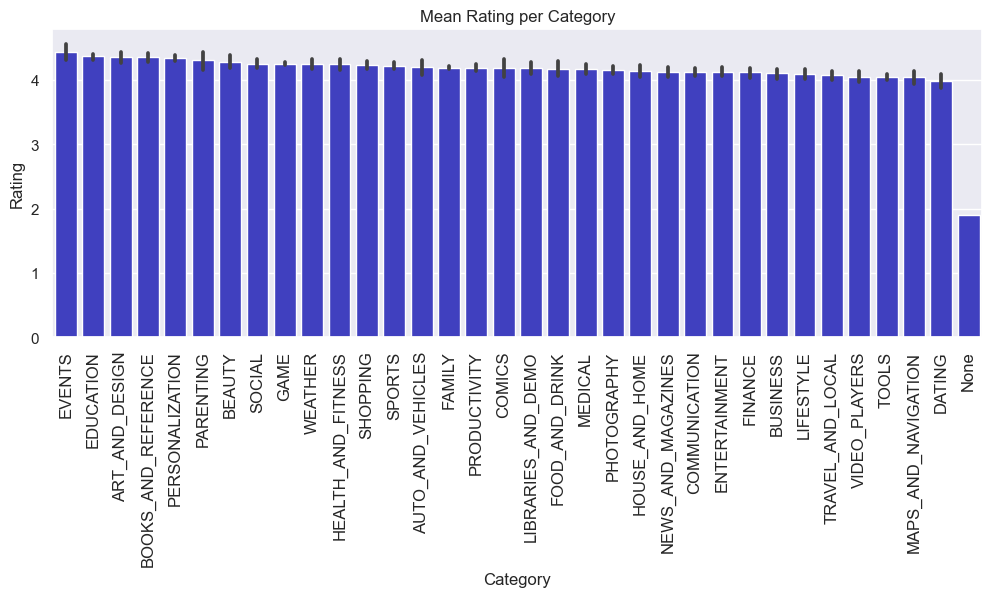

In [57]:
a = barplot(df, 'Category', 'Rating', title='Mean Rating per Category')

<AxesSubplot:title={'center':'Sentiment + Polarity per category'}, xlabel='Category', ylabel='Sentiment_Polarity'>

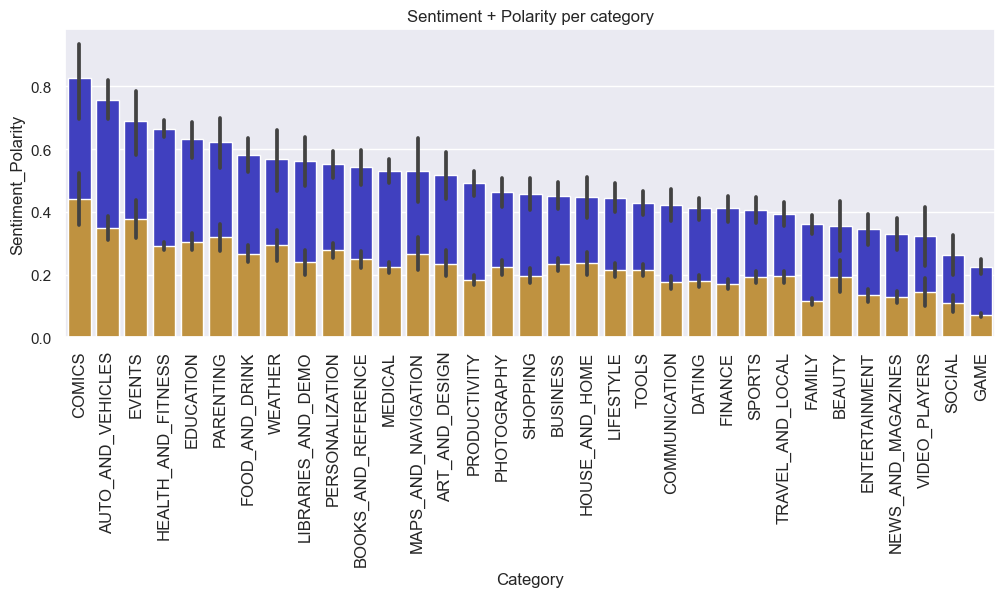

In [58]:
barplot(df_comb, 'Category', 'Sentiment')
barplot(df_comb, 'Category', 'Sentiment_Polarity', title='Sentiment + Polarity per category', color='orange', ordby='Sentiment')

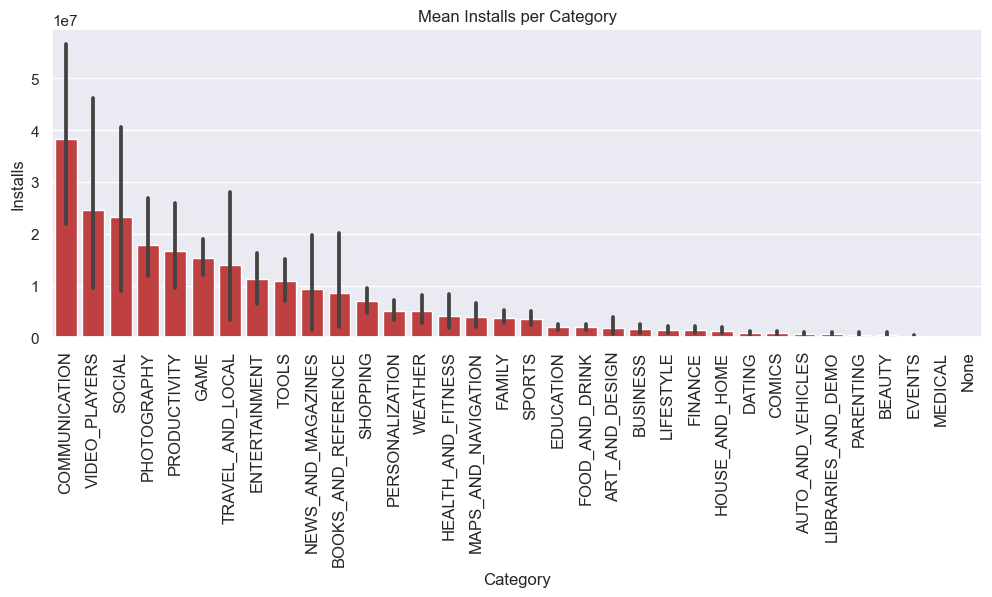

In [59]:
a = barplot(df[df['Price'] == 0], 'Category', 'Installs', color='red', title='Mean Installs per Category')

### Paid Apps

C:\Users\Geert\miniconda3\envs\WT\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Geert\miniconda3\envs\WT\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Geert\miniconda3\envs\WT\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


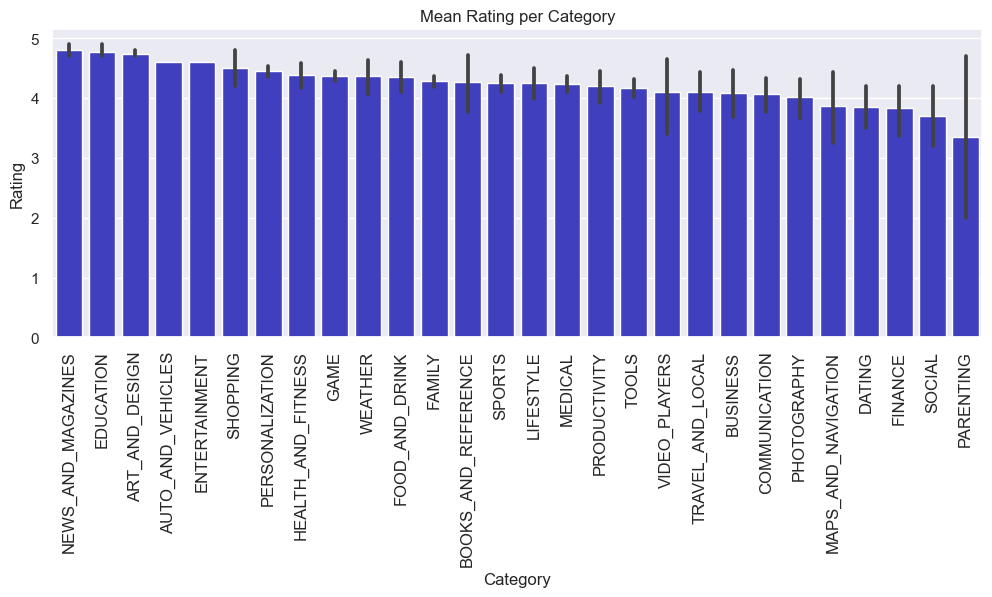

In [60]:
a = barplot(df[df['Price'] > 0], 'Category', 'Rating', title="Mean Rating per Category")

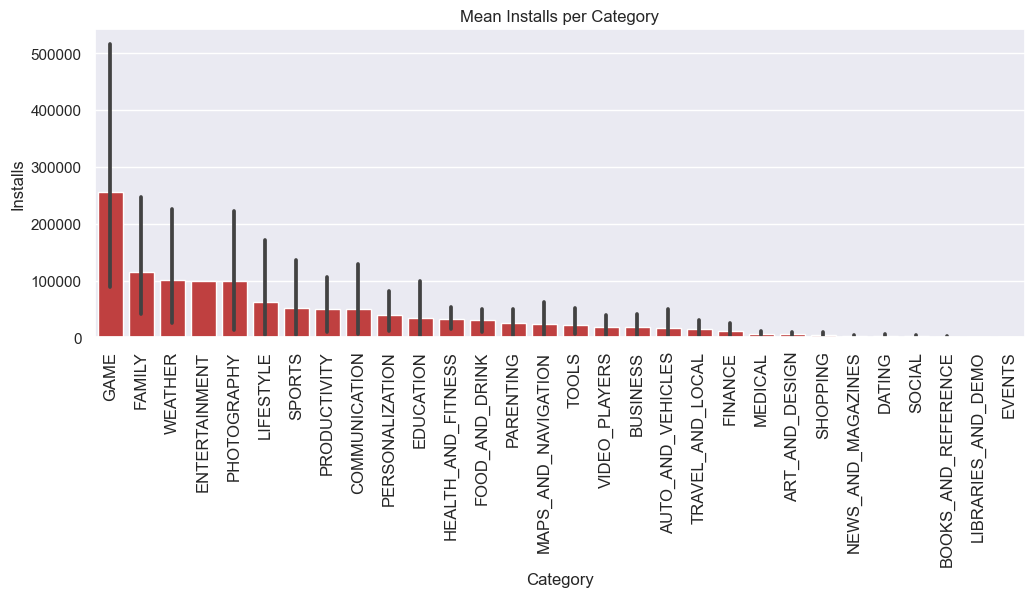

In [61]:
a = barplot(df[df['Price'] > 0], 'Category', 'Installs', color='red', title='Mean Installs per Category')

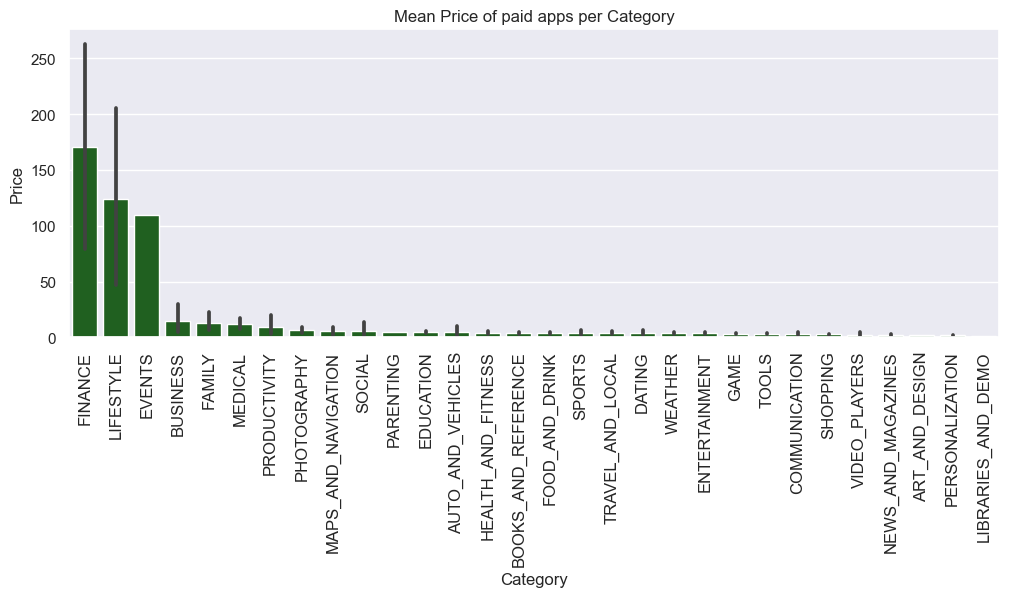

In [62]:
a = barplot(df[df['Price'] > 0], 'Category', 'Price', color='green', title='Mean Price of paid apps per Category')

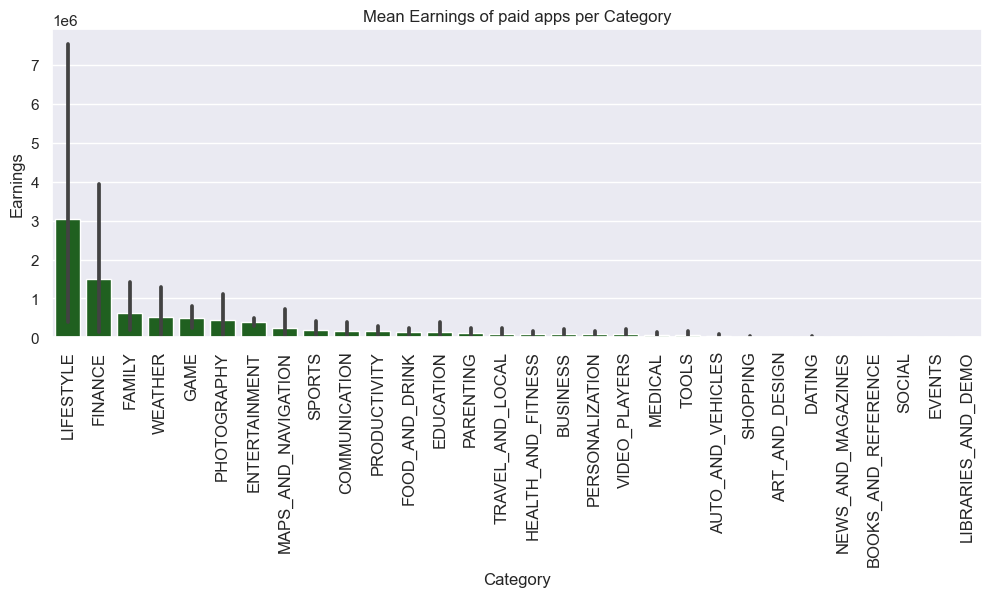

In [63]:
df['Earnings'] = df['Price'] * df['Installs']
a = barplot(df[df['Price'] > 0], 'Category', 'Earnings', color='green', title='Mean Earnings of paid apps per Category')

Of the top 5 best earning categories, only 2 have multipe genres: FAMILY and GAME.

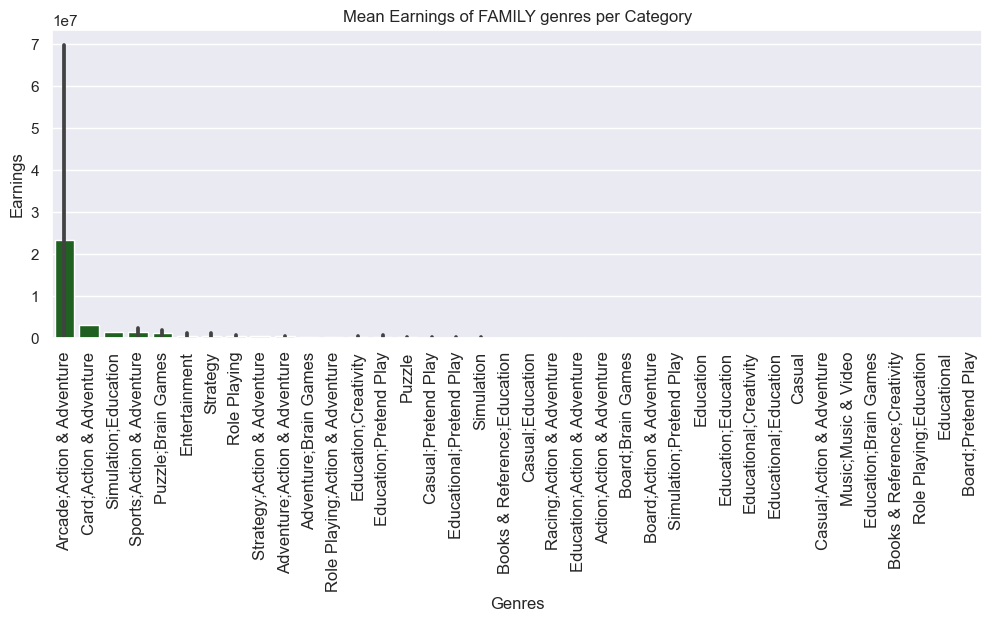

In [64]:
a = barplot(df[(df['Price'] > 0) & (df['Category'] == 'FAMILY')], 'Genres', 'Earnings', color='green', title='Mean Earnings of FAMILY genres per Category')

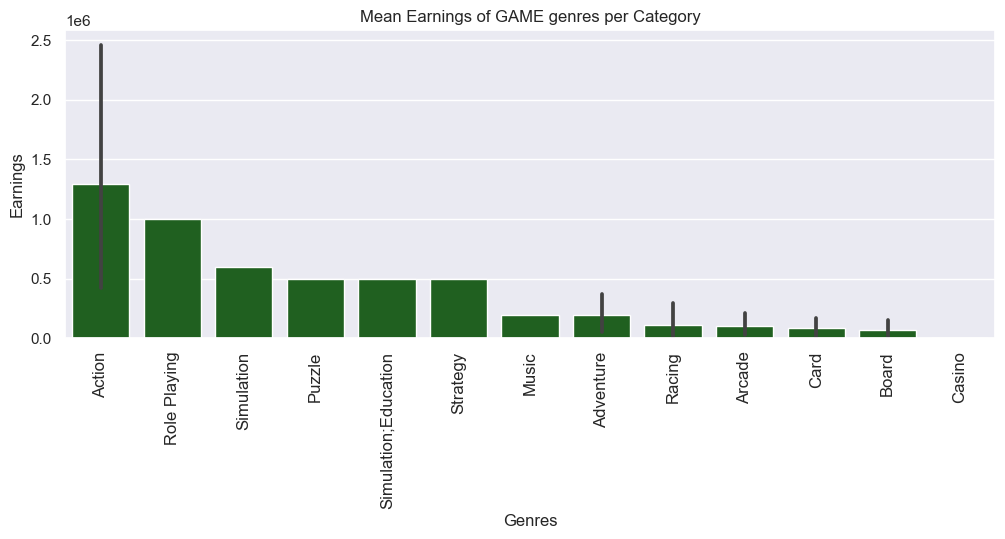

In [65]:
a = barplot(df[(df['Price'] > 0) & (df['Category'] == 'GAME')], 'Genres', 'Earnings', color='green', title='Mean Earnings of GAME genres per Category')

# Conclusion

App rating seems fairly indepent of category of app.

If you want an app that gets **downloaded many times**, the best categories are:
- Communication
- Video Players
- Social

If you want an aps that gets **good reviews**:
- Comics
- Auto and Vehicles
- Events

If you want an app that **makes the most money** (up-front), the best categories are:
- Lifestyle
- Finance
- Games (Since FAMILY apps seem to be GAME apps) 

If you want to make **games**, the best earning genres are:
- Action (& adventure)
- Role Playing

Although games are the most downloaded paid apps, their low prices mean lower overall earnings.  
Also, their reviews are often the most negative, although this does not reflect in the ratings
